In [1]:
import girder_client as gc
from pprint import pprint
import sys, os
from IPython.display import Image
API_URL = "http://candygram.neurology.emory.edu:8080/api/v1"
## DOWNLOADS X=0 TO 100 AND Y=0 30

dsaGC = gc.GirderClient(apiUrl=API_URL)


In [2]:
## Figure out the ID for the TCGA collection

TCGAColID = ""

for c in dsaGC.listCollection():
    if 'TCGA' in c['name']:
        print c
    ## Note there's more than one collection with the word TCGA in it! Be Careful
    if c['name'] == "TCGA":
        TCGAColID = c['_id']

{u'size': 17627563848078, u'updated': u'2017-06-30T20:44:55.655000+00:00', u'publicFlags': [], u'description': None, u'created': u'2017-06-30T20:44:55.655000+00:00', u'public': True, u'_id': u'5956b84792ca9a000dd670c8', u'_modelType': u'collection', u'_accessLevel': 0, u'name': u'TCGA'}
{u'size': 21112175894, u'updated': u'2017-07-05T17:14:45.021000+00:00', u'publicFlags': [], u'description': u'This will contain APERIO, PDFs and other Clinical Related TCGA Metadata', u'created': u'2017-07-05T17:14:45.021000+00:00', u'public': True, u'_id': u'595d1e8592ca9a000dd5737d', u'_modelType': u'collection', u'_accessLevel': 0, u'name': u'TCGA_METADATA'}


In [3]:
from pprint import pprint

class LinePrinter():
    """
    Print things to stdout on one line dynamically
    """
    def __init__(self,data):
        sys.stdout.write("\r\x1b[K"+data.__str__())
        sys.stdout.flush()

In [4]:
##going to use some of the special tcga endpoints to make my life a little easier
TCGACohortList = dsaGC.get('/tcga/cohort')

cohortData = {}

for x in  TCGACohortList['data']:
    cohortData[x['lowerName']] = { '_id': x['_id'], 'lowerName': x['lowerName']}


In [15]:
## get the cases for the cohort

dxSlidesFound = 0
totalSlidesFound = 0
collsProcessed = 0
slidesOnDisk = 0
cohortsProcessed = 0

for cohort,data in cohortData.iteritems():
    slideList = dsaGC.get('/tcga/cohort/%s/images?&limit=9000' % data['_id'])
    ## I only want to get images that end in DX1 for now
#     print "\nProcessing cohort %s " % cohort
    cohortsProcessed+=1 
    dxSlidesForCohort = []
    
    for sld in slideList['data']:
        totalSlidesFound +=1
        
        if 'DX1' in sld['tcga']['barcode']:
            dxSlidesFound +=1
            dxSlidesForCohort.append(sld)
        else:
            pass
        
        cohortData[cohort]['dxCaseList'] = dxSlidesForCohort
        
    ## This returns a list of slides, but also has a ton of properties that can get confusing for non experts
    #print len(slideList.data)
    LinePrinter( "Processed Cohort %d/%d: %d slides, and found %d slides" % (cohortsProcessed, len(cohortData),totalSlidesFound, dxSlidesFound))
    
#     GET /tcga/cohort/{id}/images
# List slide images in a cohort


Processed Cohort 33/33: 32854 slides, and found 10764 slides

In [16]:
print len( cohortData['gbm']['dxCaseList'])

macroImageRootPath = '/home/dagutman/Documents/tcga_imgs/macro_thumbnails/'


imgWidth = 256


slidesProcessed = slidesDownloaded = 0


for cohort,data in cohortData.iteritems():
    try:
        slideSet = data['dxCaseList']
    except:
        print "Cant find case list??"
        print data
        
    for sld in slideSet:
        slidesProcessed +=1 

        ##filename will have the word macro.thumb.width
        outputPath = os.path.join(macroImageRootPath,cohort)
        if not os.path.isdir(outputPath):
            os.makedirs(outputPath)
        outputFile = os.path.join(outputPath,sld['name']+'.macro.thumb.256.jpeg')

        if not os.path.isfile(outputFile):
            curImageMacroUrl = '/item/%s/tiles/thumbnail?width=%s' % (sld['_id'],imgWidth)
            curImage = dsaGC.get(curImageMacroUrl,  jsonResp=False)        
            with open(outputFile,"wb") as fp:
                fp.write(curImage.content)
            slidesDownloaded +=1
        
        LinePrinter("You have processed %d files and just downloaded %d" % (slidesProcessed,slidesDownloaded))
        


762
You have processed 5274 files and just downloaded 0Cant find case list??
{'lowerName': u'sample images', '_id': u'597a146692ca9a000d39f836'}
You have processed 10885 files and just downloaded 0

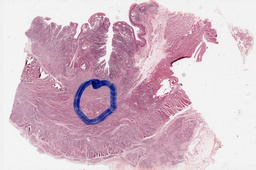

In [72]:
w

In [102]:
## Copy Data to Training/Testing/Validation Directory
import shutil
import random
import math
import glob
## Dare I use a HARD LINK??

def copyDataCohort( imgList, baseTargetDir, trainProportion=0.75,validationProportion=0.05,testingProportion=0.2,emptyTargetDir = True):
    
    
    random.shuffle(imgList)
    
    train = []
    test = []
    validate = []
    for i in imgList:
        rnd = random.random()
        
        if rnd < trainProportion:
            train.append(i)
        elif (rnd >= trainProportion  and rnd < (trainProportion + validationProportion) ):
            validate.append(i)
        else:
            test.append(i)
    
    ## Now copy the training/testing and validation data
    for i in train:
        td = os.path.join(baseTargetDir,'train')
        if not os.path.isdir(td):
            os.makedirs(td)
        shutil.copy2(i,td)
    
    
    
    ## Now copy the images print len(test),len(train),len(validate)

In [103]:
blcaImgSet = glob.glob(macroImageRootPath+'blca/*.jpeg')

tgtDir = '/home/dagutman/Documents/tcga_imgs/dataSetsForDL/'

copyDataCohort(blcaImgSet,tgtDir+'blca')